# COVID 19 global deaths projection

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from matplotlib.dates import MonthLocator, WeekdayLocator

In [14]:
projected = pd.read_csv('projection.csv', index_col=0, parse_dates=True)
deaths_raw = pd.read_csv('deaths.csv')['deaths'].values
# deaths_raw = pd.read_csv('deaths-20200501.csv')['deaths'].values
deaths_raw

array([    58,    123,    177,    250,    317,    402,    485,    587,
          694,    799,   1027,   1225,   1496,   1828,   2181,   2628,
         3033,   3720,   4362,   5179,   6151,   7263,   8640,  10284,
        11939,  13871,  16357,  18946,  21891,  25360,  29031,  32374,
        36534,  41243,  46433,  52703,  58665,  64731,  69735,  75341,
        83233,  89968,  97634, 104981, 111189, 116754, 122393, 129801,
       137991, 144989, 153418, 160094, 164988, 170477, 177761, 184459,
       191164, 197581, 203682, 207439, 211948, 218636, 225229, 231024,
       236648, 241863, 245345, 249440, 255226, 262037, 267626, 273176,
       277424, 280934, 284337, 289651, 294965, 300282, 305354])

In [15]:
w = 7
hw = w//2
dates = pd.date_range(start='2020-02-27', periods=len(deaths_raw))
ddf = pd.DataFrame({'deaths':deaths_raw}, index=dates)
ddf['ma'] = ddf['deaths'].rolling(window=w).mean()
ddf['ma_shift'] = ddf['ma'].shift(-hw)

ddf['diff'] = ddf['deaths'] - ddf['deaths'].shift(1)
ddf['ma_shift_diff'] = ddf['ma_shift'] - ddf['ma_shift'].shift(1)
ddf['ma_shift_gf'] = ddf['ma_shift_diff'] / ddf['ma_shift_diff'].shift(1)
ddf['ma_shift_gf_ma'] = ddf['ma_shift_gf'].rolling(window=w).mean().shift(-hw)

In [16]:
last_day_new = ddf['ma_shift_diff'].tail(hw+1).head(1).mean()
g_factor = ddf['ma_shift_gf'].rolling(7).mean().tail(10).head(10-3).mean()
decay_n = int(1 / (1 - g_factor))
print('last_day_new', last_day_new)
print('g_factor', g_factor, 1-g_factor)
print('n', decay_n)
print('projected total', deaths_raw[-1] + last_day_new * decay_n)

def gen_decay(initial, get_r=False):
    x = initial
    r = g_factor
    rv = -0.001
    ra = 0.00003
    def gen(n):
        nonlocal x, r, rv
        x = x * r
        r -= rv
        rv += ra
        return x if not get_r else r
    return gen

f = np.vectorize(gen_decay(last_day_new))
g = np.vectorize(gen_decay(last_day_new, get_r=True))

dlen = len(ddf)
plen = 130

diff_projected = np.fromfunction(f, (plen,))
r_projected = np.fromfunction(g, (plen,))
projected_deaths = deaths_raw[-1] + diff_projected.cumsum()

ddf_proj = ddf.append(pd.DataFrame({ 'ma_shift': projected_deaths }, index=pd.date_range(dates[-1] + dates.freq, periods=plen)))
ddf_proj.iloc[dlen-hw:dlen-hw+len(diff_projected), 4] = diff_projected
ddf_proj.iloc[dlen-2*hw:dlen-2*hw+len(r_projected), 6] = r_projected

last_day_new 4596.8571428571595
g_factor 0.987530042588921 0.012469957411079036
n 80
projected total 673102.5714285728


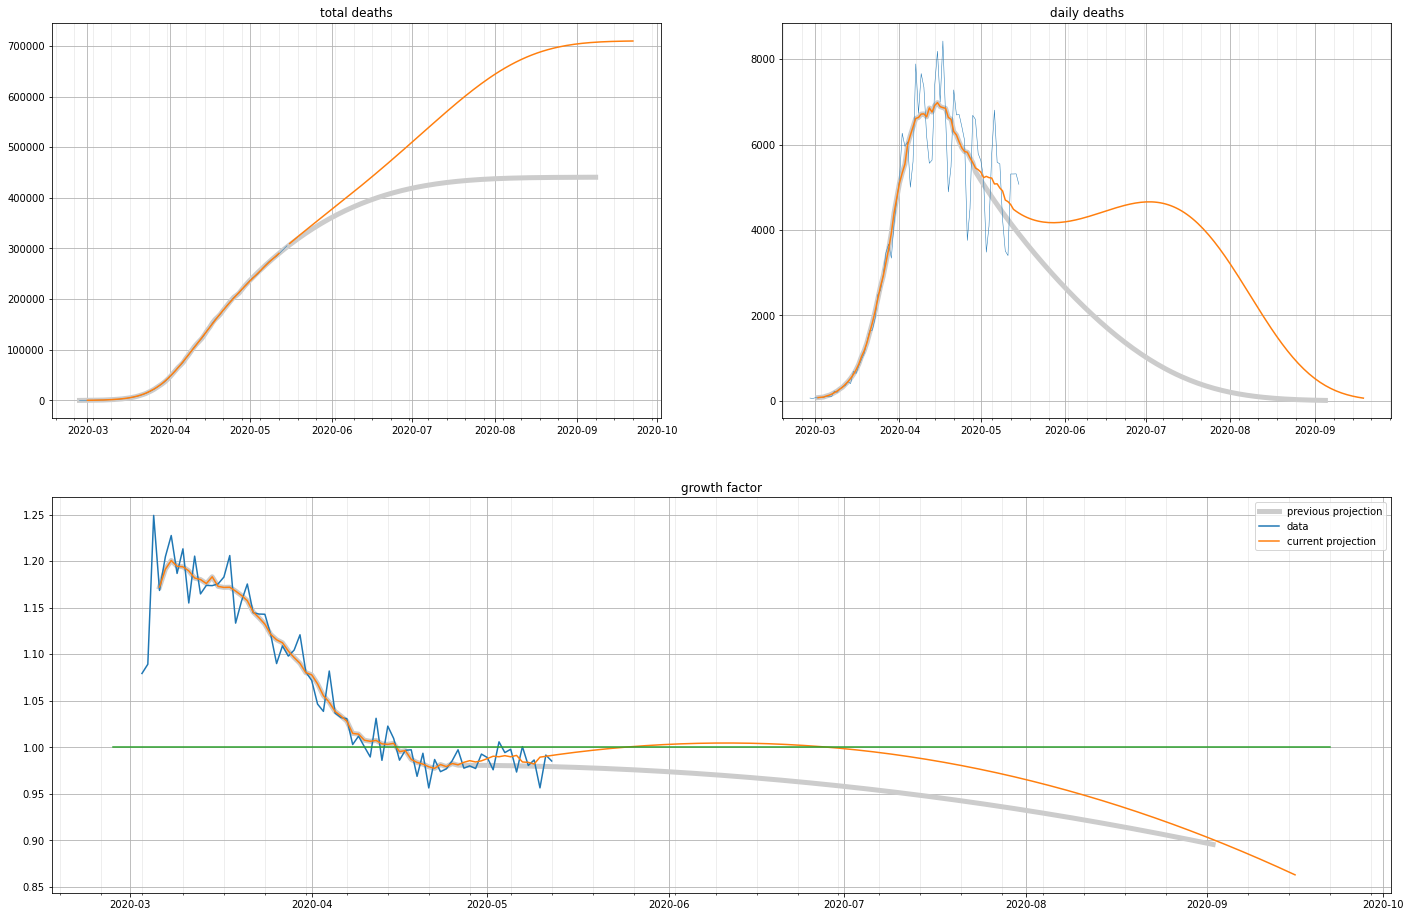

In [19]:
def configure_grid(ax):
    mloc = MonthLocator()
    wloc = WeekdayLocator()
    ax.xaxis.set_major_locator(mloc)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_minor_locator(wloc)
    ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax.grid(True)

fig = plt.figure()
fig.set_size_inches(24, 16)

gs = fig.add_gridspec(2,2)
ax0 = fig.add_subplot(gs[0,0], title='total deaths')
ax1 = fig.add_subplot(gs[0,1], title='daily deaths')
ax2 = fig.add_subplot(gs[1,:], title='growth factor')
configure_grid(ax0)
configure_grid(ax1)
configure_grid(ax2)

ax0.plot(projected['deaths'], lw=5, color='#ccc')
ax0.plot(ddf_proj['deaths'], lw=0.5)
ax0.plot(ddf_proj['ma_shift'])

ax1.plot(projected['ma_shift_diff'], lw=5, color='#ccc')
ax1.plot(ddf_proj['diff'], lw=0.5)
ax1.plot(ddf_proj['ma_shift_diff'])

ax2.plot(projected['ma_shift_gf_ma'], lw=5, color='#ccc', label='previous projection')
ax2.plot(ddf_proj['ma_shift_gf'], label='data')
ax2.plot(ddf_proj['ma_shift_gf_ma'], label='current projection')
ax2.plot([ddf_proj.index[0],ddf_proj.index[-1]], [1,1])

plt.legend()
plt.show()